In [1]:
import pandas as pd

gemini_features = [
    "AGEP_A",          # age (years, 18‑85 top‑coded)
    "SEX_A",           # sex
    "HISPALLP_A",      # combined race / ethnicity
    "EDUCP_A",         # education level
    "BMICAT_A",        # BMI category
    "SMKCIGST_A",      # smoking status
    "HYPEV_A",         # ever hypertension
    "CHLEV_A",         # ever high cholesterol
    "DIBEV_A",         # ever diabetes
    "PHSTAT_A",        # self‑rated health
    "DEPEV_A",         # ever depression
    "COPDEV_A",        # ever COPD / chronic bronchitis / emphysema
    "STREV_A"          # ever stroke
]

target_columns = ['CHDEV_A', 'ANGEV_A', 'MIEV_A']

data_df = pd.read_csv('adult23.csv')
data_df = data_df[gemini_features + target_columns]

data_df

,AGEP_A,SEX_A,HISPALLP_A,EDUCP_A,BMICAT_A,SMKCIGST_A,HYPEV_A,CHLEV_A,DIBEV_A,PHSTAT_A,DEPEV_A,COPDEV_A,STREV_A,CHDEV_A,ANGEV_A,MIEV_A
0,67,1,3,1,3,4,1,1,2,5,1,2,1,2,2,2
1,73,1,2,8,3,1,1,2,1,3,2,2,2,1,2,1
2,48,1,3,5,4,4,2,2,2,1,2,2,2,2,2,2
3,42,2,2,9,3,3,2,2,2,1,2,2,2,2,2,2
4,50,2,2,7,2,4,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,77,2,2,5,4,3,1,1,2,3,1,1,2,2,2,2
29518,59,2,2,7,3,4,2,1,2,1,1,2,2,2,2,2
29519,66,1,2,8,4,4,2,2,2,3,2,2,2,2,2,2
29520,53,2,2,7,3,1,1,2,2,2,2,2,2,2,2,2


In [2]:
def map_codes(col, mapping, unknown="Unknown"):
    """Map numeric codes to text; keep <NA>; anything else → 'Unknown'."""
    return (
        col.replace(mapping)          # map known codes
           .mask(col.isna(), pd.NA)   # preserve genuine <NA>
           .fillna(unknown)           # leftover unusual codes
           .astype("string")
    )

data_df["SEX_A"] = map_codes(data_df["SEX_A"], {1: "Male",  2: "Female"})

data_df["HISPALLP_A"] = map_codes(data_df["HISPALLP_A"],{
    1: "Hispanic", 2: "White‑NH", 3: "Black‑NH", 4: "Asian‑NH",
    5: "AIAN‑NH",  6: "AIAN+Other", 7: "Other"})

data_df["EDUCP_A"] = map_codes(data_df["EDUCP_A"], {
    0: "None/KG", 1: "1–11th", 2: "12th/no dip", 3: "GED",
    4: "HS Grad", 5: "Some College", 6: "Assoc‑Occ/Voc",
    7: "Assoc‑Acad", 8: "Bachelor", 9: "Master", 10: "Prof/PhD"})

data_df["BMICAT_A"] = map_codes(data_df["BMICAT_A"], {
    1: "Under", 2: "Normal", 3: "Over", 4: "Obese", 5: "ExtObese"})

data_df["SMKCIGST_A"] = map_codes(data_df["SMKCIGST_A"], {
    1: "Every day", 2: "Some days", 3: "Former", 4: "Never"})

data_df["PHSTAT_A"] = map_codes(data_df["PHSTAT_A"], {
    1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"})

binary_variables = ["HYPEV_A", "CHLEV_A", "DIBEV_A", "DEPEV_A", "COPDEV_A", "STREV_A"]

for col in binary_variables:
    data_df[col] = map_codes(data_df[col], {1: "Yes", 2: "No"})

In [3]:
data_df["heart_disease"] = (
    (data_df["CHDEV_A"] == 1) | 
    (data_df["ANGEV_A"] == 1) | 
    (data_df["MIEV_A"] == 1)
).astype(int)

X = data_df.drop(columns=["heart_disease"] + target_columns)
y = data_df["heart_disease"]

# Defining the categorical and numerical columns (just age in this case)
cat_cols = X.columns.tolist()           
cat_cols.remove("AGEP_A")

In [4]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV

cat_dtypes = ["category", "object", "string"]
cat_cols = X.select_dtypes(include=cat_dtypes).columns.tolist()

num_cols = [c for c in X.columns if c not in cat_cols]

X[cat_cols] = X[cat_cols].astype("string").fillna("__MISSING__")

X[num_cols] = X[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

cb = CatBoostClassifier(
    loss_function="Logloss",
    random_seed=42,
    verbose=0
)

param_grid_cb = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200],
    'l2_leaf_reg': [3, 5, 7]
}

# 3) wrap in GridSearchCV
grid_cb = GridSearchCV(
    estimator=cb,
    param_grid=param_grid_cb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 4) fit—pass cat_features so CatBoost knows which columns are categorical
grid_cb.fit(
    X_train,
    y_train,
    cat_features=cat_cols
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   8.8s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   8.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   9.0s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   9.1s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   9.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   9.7s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   9.8s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   9.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=  10.1s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=  10.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x16eb02450>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [200],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1', verbose=2)

In [5]:
from sklearn.metrics import f1_score

best_cb = grid_cb.best_estimator_
print("Best CatBoost params:", grid_cb.best_params_)

Best CatBoost params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [ ]:
y_pred = best_cb.predict(X_test)
print("Test F1:", f1_score(y_test, y_pred))

Test F1: 0.18729096989966554


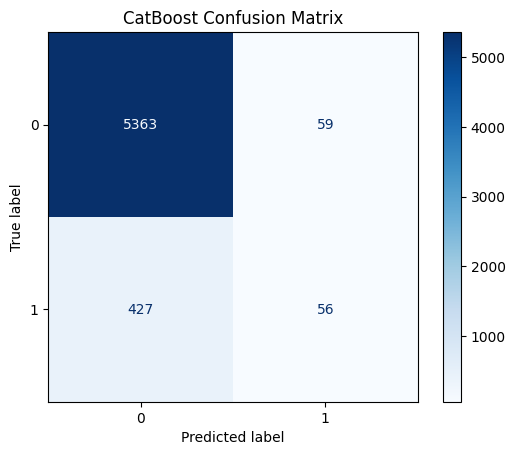

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

disp = ConfusionMatrixDisplay.from_estimator(
    best_cb, X_test, y_test, cmap=plt.cm.Blues
)
disp.ax_.set_title('CatBoost Confusion Matrix')
plt.show()

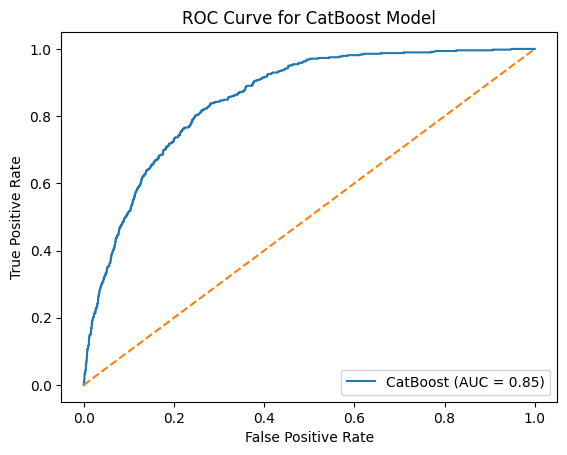

In [9]:
probs = best_cb.predict_proba(X_test)[:, 1]

# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure()
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model')
plt.legend(loc='lower right')
plt.show()

<Figure size 640x480 with 0 Axes>

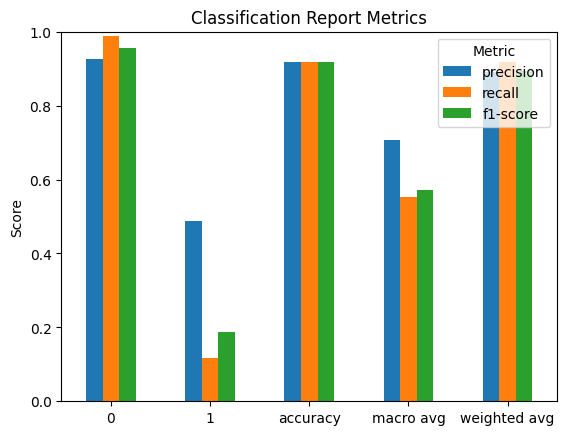

In [10]:
from sklearn.metrics import classification_report

y_pred = best_cb.predict(X_test)

# Generating classification report as a dict
report = classification_report(y_test, y_pred, output_dict=True)

# Convering to DataFrame and transposing so metrics are columns
df_report = pd.DataFrame(report).T

# 4) Select the key score columns
df_metrics = df_report[['precision', 'recall', 'f1-score']]

# 5) Plot grouped bar chart
plt.figure()
df_metrics.plot(kind='bar')
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.show()